This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $S$
    * Ionizing luminosity: $L(\mathrm{H\alpha})$
    * Distance: $d$
    * Velocity dispersion on line of sigth: $\sigma_{\text{los}}$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma_{\text{pos}}$
    * Velocity autocorrelation length scale: $r_0$
    * Structure function slope in inertial range: $m$

In [1]:
from pathlib import Path


import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle
import math
import itertools
import json
from logerr import logify



Load Table with physical properties

In [2]:
physical_data = pd.read_table('property-regions-data.csv', delimiter=',')
#physical_data = physical_data.drop(physical_data .index[[5]])

In [3]:
physical_data 

Region           LHa         LHaer       SFR     n  L [pc]  Ler [pc]  \
0   NGC 604  2.630000e+39  2.630000e+38  0.005300  0.35     400      40.0   
1   NGC 595  8.910000e+38  8.910000e+37  0.002600  1.66     400      40.0   
2  Hubble X  1.620000e+38  1.620000e+37  0.000310  0.35     160      16.0   
3  Hubble V  1.990000e+38  1.990000e+37  0.000150  0.11     130      13.0   
4     30Dor  2.930000e+39  2.930000e+38  0.013000  6.16     370      37.0   
5    Carina  3.500000e+38  3.580000e+37  0.010000  2.26     200      20.0   
6   NGC 346  6.000000e+38  6.000000e+37  0.002100  1.20     220      22.0   
7        M8  3.000000e+37  3.000000e+36  0.000100  0.44      25       2.5   
8    OrionS  1.510000e+37  1.510000e+36  0.000053  0.03       5       0.5   

   Dist [kpc]  Dister [kpc]  siglos [km/s]  sigloser [km/s]  Diam [pc]  \
0      840.00         30.00          17.51             0.30        400   
1      840.00         30.00          16.52             0.09        400   
2      500.00         40.00          10.00             0.02        160   
3      500.00         40.00           9.79             0.03        130   
4       50.00          0.19          21.77             2.20        370   
5        2.35          0.05          18.60             3.30        200   
6       61.70          1.10           9.58             1.00        220   
7        1.25          0.10          11.25             1.60         25   
8        0.40          0.02           9.90             1.20          5   

   Diamer [pc]  
0         40.0  
1         40.0  
2         16.0  
3         13.0  
4         37.0  
5         20.0  
6         22.0  
7          2.5  
8          0.5

Path names

In [4]:
datapath_names = Path(open("path-name-list.txt", "r").read()).expanduser()

In [5]:
samples=pd.read_csv(str(datapath_names) +'//sample-names-corr.csv',header=None)
Names=pd.read_csv(str(datapath_names) +'//formal-names-corr.csv',header=None)

Load Results

In [6]:
datapath_res = Path(open("path-results.txt", "r").read()).expanduser()

In [7]:
data = {}
Results = {}

for i in range(len(samples)):
    data[samples[0][i]] = json.load(open(str(datapath_res) + '/' + samples[0][i] + ".json"))

In [8]:
#sigma
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]

#velocity dispersion with 2-sig intervals
sig2 = [[0]*(1) for i in range(len(samples))]
#sig2er = [[0]*(1) for i in range(len(samples))]
sig2s2 = [[0]*(1) for i in range(len(samples))]
sig2s2p = [[0]*(1) for i in range(len(samples))]
sig2s2m = [[0]*(1) for i in range(len(samples))]

#correlation length with 2-sig intervals
r0 = [[0]*(1) for i in range(len(samples))]
#r0er = [[0]*(1) for i in range(len(samples))]
r0s2 = [[0]*(1) for i in range(len(samples))]
r0s2p = [[0]*(1) for i in range(len(samples))]
r0s2m = [[0]*(1) for i in range(len(samples))]

#power-law
m = [[0]*(1) for i in range(len(samples))]
#mer = [[0]*(1) for i in range(len(samples))]
ms2 = [[0]*(1) for i in range(len(samples))]
ms2p = [[0]*(1) for i in range(len(samples))]
ms2m = [[0]*(1) for i in range(len(samples))]

#noise with 2-sig intervals
bn = [[0]*(1) for i in range(len(samples))]
#ner = [[0]*(1) for i in range(len(samples))]
bns2 = [[0]*(1) for i in range(len(samples))]
bns2p = [[0]*(1) for i in range(len(samples))]
bns2m = [[0]*(1) for i in range(len(samples))]

#seeing with 2-sig intervals
s0 = [[0]*(1) for i in range(len(samples))]
#s0er = [[0]*(1) for i in range(len(samples))]
s0s2 = [[0]*(1) for i in range(len(samples))]
s0s2p = [[0]*(1) for i in range(len(samples))]
s0s2m = [[0]*(1) for i in range(len(samples))]

pc = [[0]*(1) for i in range(len(samples))]
box_size = [[0]*(1) for i in range(len(samples))]

In [9]:
results_='results_1sig'

for i in range(len(samples)):    
    
    sig2[i] = data[samples[0][i]][results_]['sig2'][0]
    sig2s2p[i] = data[samples[0][i]][results_]['sig2'][1]
    sig2s2m[i] = data[samples[0][i]][results_]['sig2'][2]
    
    r0[i]    = data[samples[0][i]][results_]['r0'][0]
    r0s2p[i] = data[samples[0][i]][results_]['r0'][1]
    r0s2m[i] = data[samples[0][i]][results_]['r0'][2]
    
    m[i]    = data[samples[0][i]][results_]['m'][0]
    ms2p[i] = data[samples[0][i]][results_]['m'][1]
    ms2m[i] = data[samples[0][i]][results_]['m'][2]
    
    bn[i]    = data[samples[0][i]][results_]['noise'][0]
    bns2p[i] = data[samples[0][i]][results_]['noise'][1]
    bns2m[i] = data[samples[0][i]][results_]['noise'][2]
    
    s0[i]    = data[samples[0][i]][results_]['s0'][0]
    s0s2p[i] = data[samples[0][i]][results_]['s0'][1]
    s0s2m[i] = data[samples[0][i]][results_]['s0'][2]
    
    box_size[i] = data[samples[0][i]]['properties']['box_size']
    pc[i] = data[samples[0][i]]['properties']['pc']

In [10]:
s0f = pd.DataFrame(
    {
        "s0 [RMS]":s0,
        "s0+[RMS]": s0s2p,
        "s0-[RMS]": s0s2m,  
       "s0 [FWHM]": np.array(s0)*2.35/np.array(pc),
       "s0- [FWHM]": np.array(s0s2m)*2.35/np.array(pc),
       "s0+ [FWHM]": np.array(s0s2p)*2.35/np.array(pc),
        "bn ":bn,
        "bn+": bns2p,
        "bn- ": bns2m,     
    }
)

s0f.insert(loc=0, column='Region', value=Names)


s0f.round(4)

Region  s0 [RMS]  s0+[RMS]  s0-[RMS]  s0 [FWHM]  s0- [FWHM]  s0+ [FWHM]  \
0   NGC 604    2.1078    0.7906    0.2963     1.2163      0.1710      0.4562   
1   NGC 595    0.4072    0.3393   -0.0362     0.2350     -0.0209      0.1958   
2  Hubble X    0.3624    0.1853    0.0546     0.3513      0.0529      0.1796   
3  Hubble V    0.3412    0.3549   -0.0249     0.3307     -0.0242      0.3440   
4    30 Dor    0.1577    0.0468    0.0196     1.5288      0.1896      0.4541   
5    Carina    0.0075    0.0059    0.0041     1.7042      0.9325      1.3365   
6   NGC 346    0.1115    0.0145    0.0084     0.8718      0.0654      0.1136   
7        M8    0.0070    0.0008    0.0050     2.7083      1.9447      0.3250   
8     Orion    0.0020    0.0001    0.0001     2.3995      0.1179      0.1696   

      bn      bn+    bn-   
0  0.3275  0.3764  0.2036  
1  1.5372  1.0738  0.3755  
2  0.3211  0.2588  0.1420  
3  0.0000  0.4548 -0.0720  
4  6.1556  0.8933  0.7219  
5  2.2569  1.4413  1.0625  
6  0.8402  0.0390  0.0334  
7  0.4367  0.1039  0.1623  
8  0.0252  0.0027  0.0024

In [11]:
s1f = pd.DataFrame(
    {
        "sig2":sig2,
        "sig2+": sig2s2p,
        "sig2-": sig2s2m,
        "r0":r0,
        "r0+": r0s2p,
        "r0-": r0s2m,
        "m":m,
        "m+": ms2p,
        "m-": ms2m,
       
    }
)

s1f.insert(loc=0, column='Region', value=Names)


s1f.round(4)

Region      sig2    sig2+   sig2-       r0     r0+     r0-       m  \
0   NGC 604   85.8687  16.4962  4.1903  12.0876  2.8575  2.0318  0.7751   
1   NGC 595   53.2064   2.6751  0.5777  11.2117  0.3417  0.4644  1.3764   
2  Hubble X   14.8123   1.3008  0.2694   4.0994  0.1591  0.1351  1.0161   
3  Hubble V    9.8240   1.8946  0.0809   3.5620  0.1465  0.6473  0.8104   
4    30 Dor  297.5367  20.1299  8.0838   3.8579  0.5023  0.2234  0.8520   
5    Carina   18.1376   0.7528  0.8384   0.5505  0.0466  0.0329  1.1584   
6   NGC 346   33.0228   1.3501  0.7040   2.3737  0.1491  0.0775  0.9564   
7        M8    7.3852   0.6358  0.3672   1.0347  0.1173  0.0603  1.2639   
8     Orion   12.6480   0.3967  0.2544   0.0680  0.0032  0.0020  1.0734   

       m+      m-  
0  0.0839  0.1669  
1  0.0343  0.0849  
2  0.0349  0.1131  
3  0.0262  0.1869  
4  0.0345  0.0749  
5  0.1449  0.0940  
6  0.0231  0.0376  
7  0.0838  0.1088  
8  0.0154  0.0207

In [12]:
physical_data

Region           LHa         LHaer       SFR     n  L [pc]  Ler [pc]  \
0   NGC 604  2.630000e+39  2.630000e+38  0.005300  0.35     400      40.0   
1   NGC 595  8.910000e+38  8.910000e+37  0.002600  1.66     400      40.0   
2  Hubble X  1.620000e+38  1.620000e+37  0.000310  0.35     160      16.0   
3  Hubble V  1.990000e+38  1.990000e+37  0.000150  0.11     130      13.0   
4     30Dor  2.930000e+39  2.930000e+38  0.013000  6.16     370      37.0   
5    Carina  3.500000e+38  3.580000e+37  0.010000  2.26     200      20.0   
6   NGC 346  6.000000e+38  6.000000e+37  0.002100  1.20     220      22.0   
7        M8  3.000000e+37  3.000000e+36  0.000100  0.44      25       2.5   
8    OrionS  1.510000e+37  1.510000e+36  0.000053  0.03       5       0.5   

   Dist [kpc]  Dister [kpc]  siglos [km/s]  sigloser [km/s]  Diam [pc]  \
0      840.00         30.00          17.51             0.30        400   
1      840.00         30.00          16.52             0.09        400   
2      500.00         40.00          10.00             0.02        160   
3      500.00         40.00           9.79             0.03        130   
4       50.00          0.19          21.77             2.20        370   
5        2.35          0.05          18.60             3.30        200   
6       61.70          1.10           9.58             1.00        220   
7        1.25          0.10          11.25             1.60         25   
8        0.40          0.02           9.90             1.20          5   

   Diamer [pc]  
0         40.0  
1         40.0  
2         16.0  
3         13.0  
4         37.0  
5         20.0  
6         22.0  
7          2.5  
8          0.5

In [13]:
data = pd.DataFrame(
    {
       "Region": physical_data.Region,
       "LHa": physical_data.LHa,
       "LHaer": physical_data.LHaer,
       "SFR": physical_data.SFR,
       "n": physical_data.n,
       "L [pc]": physical_data['Diam [pc]'],
       "Ler [pc]": physical_data['Diamer [pc]'],
       "Dist [kpc]": physical_data['Dist [kpc]'],
       "Dister [kpc]": physical_data['Dister [kpc]'],
        
       "sig2 [km/s]": sig2,
       "sig2er": sig2s2p,
        "sig [km/s]": np.array(sig2)**0.5,
       "siger": (np.array(sig2s2p)/np.array(sig2))*np.array(sig2)**0.5,
        "m": m,
       "mer": ms2p,
       "r0 [pc]": r0,
       "r0er": r0s2p,
        
       "siglos [km/s]": physical_data['siglos [km/s]'],
       "sigloser [km/s]": physical_data['sigloser [km/s]'],
      
    },
)

In [14]:
data.dtypes

Region              object
LHa                float64
LHaer              float64
SFR                float64
n                  float64
L [pc]               int64
Ler [pc]           float64
Dist [kpc]         float64
Dister [kpc]       float64
sig2 [km/s]        float64
sig2er             float64
sig [km/s]         float64
siger              float64
m                  float64
mer                float64
r0 [pc]            float64
r0er               float64
siglos [km/s]      float64
sigloser [km/s]    float64
dtype: object

In [15]:
data.round(4)

Region           LHa         LHaer     SFR     n  L [pc]  Ler [pc]  \
0   NGC 604  2.630000e+39  2.630000e+38  0.0053  0.35     400      40.0   
1   NGC 595  8.910000e+38  8.910000e+37  0.0026  1.66     400      40.0   
2  Hubble X  1.620000e+38  1.620000e+37  0.0003  0.35     160      16.0   
3  Hubble V  1.990000e+38  1.990000e+37  0.0001  0.11     130      13.0   
4     30Dor  2.930000e+39  2.930000e+38  0.0130  6.16     370      37.0   
5    Carina  3.500000e+38  3.580000e+37  0.0100  2.26     200      20.0   
6   NGC 346  6.000000e+38  6.000000e+37  0.0021  1.20     220      22.0   
7        M8  3.000000e+37  3.000000e+36  0.0001  0.44      25       2.5   
8    OrionS  1.510000e+37  1.510000e+36  0.0001  0.03       5       0.5   

   Dist [kpc]  Dister [kpc]  sig2 [km/s]   sig2er  sig [km/s]   siger       m  \
0      840.00         30.00      85.8687  16.4962      9.2665  1.7802  0.7751   
1      840.00         30.00      53.2064   2.6751      7.2943  0.3667  1.3764   
2      500.00         40.00      14.8123   1.3008      3.8487  0.3380  1.0161   
3      500.00         40.00       9.8240   1.8946      3.1343  0.6045  0.8104   
4       50.00          0.19     297.5367  20.1299     17.2493  1.1670  0.8520   
5        2.35          0.05      18.1376   0.7528      4.2588  0.1768  1.1584   
6       61.70          1.10      33.0228   1.3501      5.7465  0.2349  0.9564   
7        1.25          0.10       7.3852   0.6358      2.7176  0.2340  1.2639   
8        0.40          0.02      12.6480   0.3967      3.5564  0.1115  1.0734   

      mer  r0 [pc]    r0er  siglos [km/s]  sigloser [km/s]  
0  0.0839  12.0876  2.8575          17.51             0.30  
1  0.0343  11.2117  0.3417          16.52             0.09  
2  0.0349   4.0994  0.1591          10.00             0.02  
3  0.0262   3.5620  0.1465           9.79             0.03  
4  0.0345   3.8579  0.5023          21.77             2.20  
5  0.1449   0.5505  0.0466          18.60             3.30  
6  0.0231   2.3737  0.1491           9.58             1.00  
7  0.0838   1.0347  0.1173          11.25             1.60  
8  0.0154   0.0680  0.0032           9.90             1.20

In [16]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er", "Ler [pc]", "Dister [kpc]","LHaer","sigloser [km/s]"]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

Region  log L(H) [erg s^-1]         LHaer  log SFR  log n  log L [pc]  \
0   NGC 604                39.42  2.630000e+38    -2.28  -0.46        2.60   
1   NGC 595                38.95  8.910000e+37    -2.59   0.22        2.60   
2  Hubble X                38.21  1.620000e+37    -3.51  -0.46        2.20   
3  Hubble V                38.30  1.990000e+37    -3.82  -0.96        2.11   
4     30Dor                39.47  2.930000e+38    -1.89   0.79        2.57   
5    Carina                38.54  3.580000e+37    -2.00   0.35        2.30   
6   NGC 346                38.78  6.000000e+37    -2.68   0.08        2.34   
7        M8                37.48  3.000000e+36    -4.00  -0.36        1.40   
8    OrionS                37.18  1.510000e+36    -4.28  -1.52        0.70   

   Ler [pc]  log Dist [kpc]  Dister [kpc]  log sig2 [km/s]     sig2er  \
0      40.0            2.92         30.00             1.93  16.496228   
1      40.0            2.92         30.00             1.73   2.675113   
2      16.0            2.70         40.00             1.17   1.300753   
3      13.0            2.70         40.00             0.99   1.894628   
4      37.0            1.70          0.19             2.47  20.129857   
5      20.0            0.37          0.05             1.26   0.752841   
6      22.0            1.79          1.10             1.52   1.350080   
7       2.5            0.10          0.10             0.87   0.635802   
8       0.5           -0.40          0.02             1.10   0.396671   

   log sig [km/s]     siger         m       mer  log r0 [pc]      r0er  \
0            0.97  1.780193  0.775075  0.083881         1.08  2.857540   
1            0.86  0.366742  1.376368  0.034288         1.05  0.341687   
2            0.59  0.337975  1.016097  0.034877         0.61  0.159073   
3            0.50  0.604475  0.810433  0.026176         0.55  0.146501   
4            1.24  1.166999  0.851961  0.034487         0.59  0.502290   
5            0.63  0.176772  1.158353  0.144906        -0.26  0.046570   
6            0.76  0.234938  0.956389  0.023103         0.38  0.149143   
7            0.43  0.233960  1.263906  0.083826         0.01  0.117271   
8            0.55  0.111537  1.073374  0.015441        -1.17  0.003222   

   log siglos [km/s]  sigloser [km/s]  
0               1.24             0.30  
1               1.22             0.09  
2               1.00             0.02  
3               0.99             0.03  
4               1.34             2.20  
5               1.27             3.30  
6               0.98             1.00  
7               1.05             1.60  
8               1.00             1.20

Uncertainties Log Space

In [17]:
logdata['Ler [pc]']=(data['Ler [pc]']/data['L [pc]'])*0.434
logdata['sigloser [km/s]']=(data['sigloser [km/s]']/data['siglos [km/s]'])*0.434
logdata['LHaer']=(data['LHaer']/data['LHa'])*0.434
logdata['Dister [kpc]']=(data['Dister [kpc]']/data['Dist [kpc]'])*0.434
logdata['mer']=(data['mer']/data['m'])*0.434
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434

In [18]:
logdata

Region  log L(H) [erg s^-1]     LHaer  log SFR  log n  log L [pc]  \
0   NGC 604                39.42  0.043400    -2.28  -0.46        2.60   
1   NGC 595                38.95  0.043400    -2.59   0.22        2.60   
2  Hubble X                38.21  0.043400    -3.51  -0.46        2.20   
3  Hubble V                38.30  0.043400    -3.82  -0.96        2.11   
4     30Dor                39.47  0.043400    -1.89   0.79        2.57   
5    Carina                38.54  0.044392    -2.00   0.35        2.30   
6   NGC 346                38.78  0.043400    -2.68   0.08        2.34   
7        M8                37.48  0.043400    -4.00  -0.36        1.40   
8    OrionS                37.18  0.043400    -4.28  -1.52        0.70   

   Ler [pc]  log Dist [kpc]  Dister [kpc]  log sig2 [km/s]    sig2er  \
0    0.0434            2.92      0.015500             1.93  0.083376   
1    0.0434            2.92      0.015500             1.73  0.021821   
2    0.0434            2.70      0.034720             1.17  0.038112   
3    0.0434            2.70      0.034720             0.99  0.083700   
4    0.0434            1.70      0.001649             2.47  0.029362   
5    0.0434            0.37      0.009234             1.26  0.018014   
6    0.0434            1.79      0.007737             1.52  0.017743   
7    0.0434            0.10      0.034720             0.87  0.037364   
8    0.0434           -0.40      0.021700             1.10  0.013611   

   log sig [km/s]     siger         m       mer  log r0 [pc]      r0er  \
0            0.97  0.083376  0.775075  0.046969         1.08  0.102599   
1            0.86  0.021821  1.376368  0.010812         1.05  0.013227   
2            0.59  0.038112  1.016097  0.014897         0.61  0.016841   
3            0.50  0.083700  0.810433  0.014018         0.55  0.017850   
4            1.24  0.029362  0.851961  0.017568         0.59  0.056507   
5            0.63  0.018014  1.158353  0.054292        -0.26  0.036718   
6            0.76  0.017743  0.956389  0.010484         0.38  0.027269   
7            0.43  0.037364  1.263906  0.028784         0.01  0.049188   
8            0.55  0.013611  1.073374  0.006243        -1.17  0.020579   

   log siglos [km/s]  sigloser [km/s]  
0               1.24         0.007436  
1               1.22         0.002364  
2               1.00         0.000868  
3               0.99         0.001330  
4               1.34         0.043859  
5               1.27         0.077000  
6               0.98         0.045303  
7               1.05         0.061724  
8               1.00         0.052606

In [19]:
#logify(data['L [pc]'],data['Ler [pc]'])

Make the label text bigger on the figures

In [20]:
sns.set_context("talk")

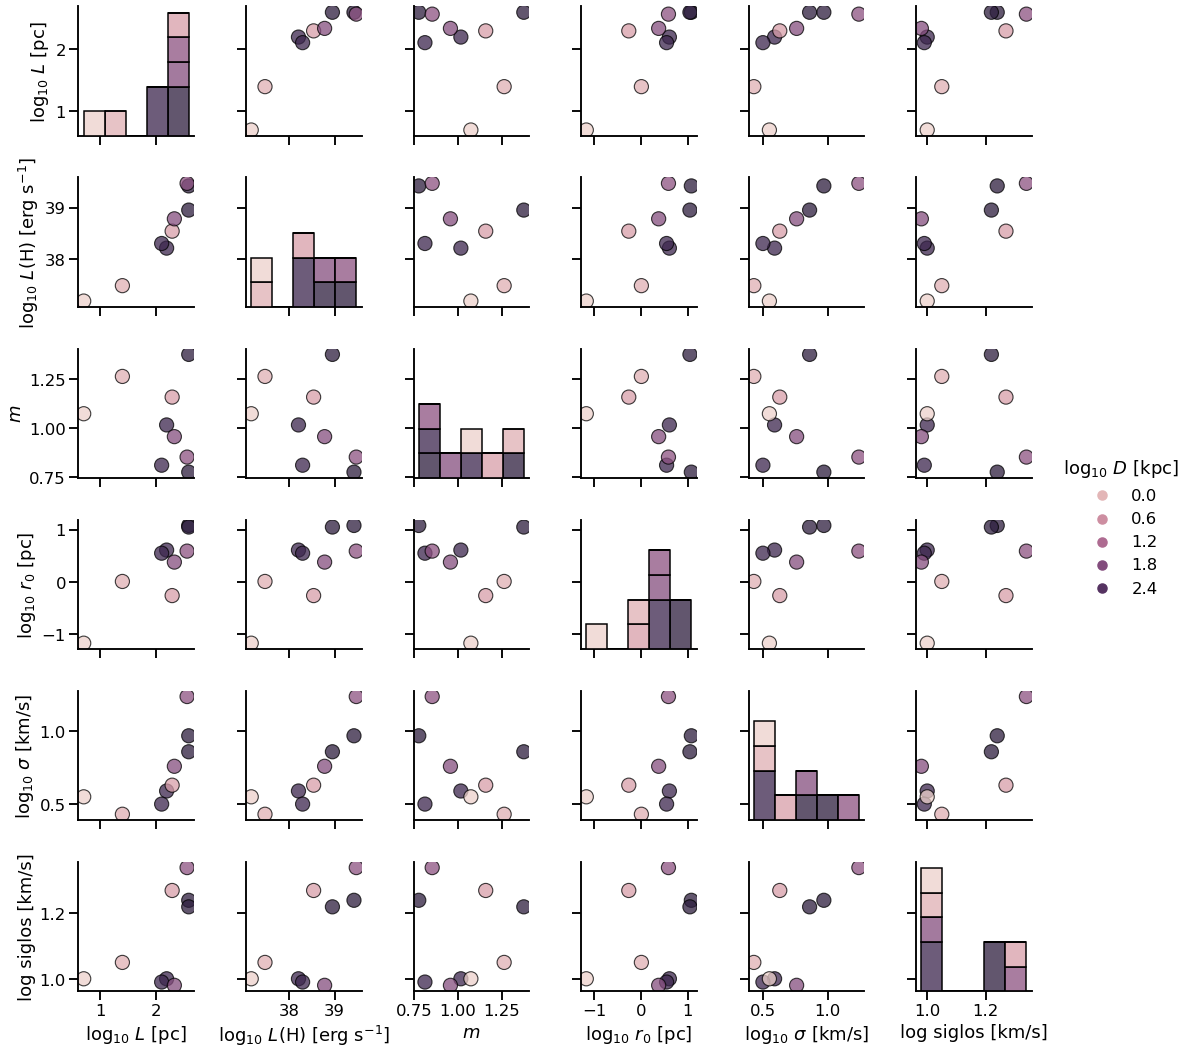

In [21]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [22]:
logdata[selected_vars].corr()

log L [pc]  log L(H) [erg s^-1]  log Dist [kpc]  \
log L [pc]             1.000000             0.927668        0.767302   
log L(H) [erg s^-1]    0.927668             1.000000        0.672210   
log Dist [kpc]         0.767302             0.672210        1.000000   
m                     -0.243028            -0.393622       -0.352181   
log r0 [pc]            0.859830             0.772491        0.912951   
log sig [km/s]         0.644201             0.858891        0.394427   
log siglos [km/s]      0.561549             0.690445        0.113487   

                            m  log r0 [pc]  log sig [km/s]  log siglos [km/s]  
log L [pc]          -0.243028     0.859830        0.644201           0.561549  
log L(H) [erg s^-1] -0.393622     0.772491        0.858891           0.690445  
log Dist [kpc]      -0.352181     0.912951        0.394427           0.113487  
m                    1.000000    -0.221981       -0.342339           0.012817  
log r0 [pc]         -0.221981     1.000000        0.506477           0.325497  
log sig [km/s]      -0.342339     0.506477        1.000000           0.749648  
log siglos [km/s]    0.012817     0.325497        0.749648           1.000000

So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosityâ€“distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values. 

## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [23]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [24]:
import scipy.stats

In [25]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)

In [26]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

r          t             p
0   0.000   0.000000  5.000000e-01
1   0.200   0.540062  3.019294e-01
2   0.400   1.154701  1.407685e-01
3   0.500   1.527525  8.257494e-02
4   0.600   1.984313  4.124805e-02
5   0.700   2.593355  1.597303e-02
6   0.779   3.287020  5.535582e-03
7   0.800   3.527668  3.879201e-03
8   0.900   5.462793  2.997718e-04
9   0.908   5.733922  2.184923e-04
10  0.950   8.049526  2.088479e-05
11  0.981  13.378240  4.662338e-07

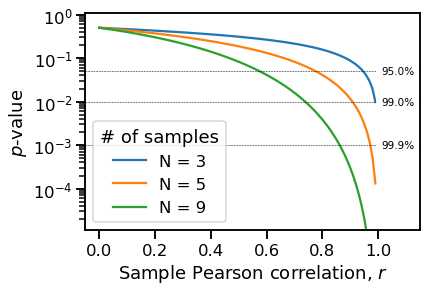

In [27]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [28]:
logdata

Region  log L(H) [erg s^-1]     LHaer  log SFR  log n  log L [pc]  \
0   NGC 604                39.42  0.043400    -2.28  -0.46        2.60   
1   NGC 595                38.95  0.043400    -2.59   0.22        2.60   
2  Hubble X                38.21  0.043400    -3.51  -0.46        2.20   
3  Hubble V                38.30  0.043400    -3.82  -0.96        2.11   
4     30Dor                39.47  0.043400    -1.89   0.79        2.57   
5    Carina                38.54  0.044392    -2.00   0.35        2.30   
6   NGC 346                38.78  0.043400    -2.68   0.08        2.34   
7        M8                37.48  0.043400    -4.00  -0.36        1.40   
8    OrionS                37.18  0.043400    -4.28  -1.52        0.70   

   Ler [pc]  log Dist [kpc]  Dister [kpc]  log sig2 [km/s]    sig2er  \
0    0.0434            2.92      0.015500             1.93  0.083376   
1    0.0434            2.92      0.015500             1.73  0.021821   
2    0.0434            2.70      0.034720             1.17  0.038112   
3    0.0434            2.70      0.034720             0.99  0.083700   
4    0.0434            1.70      0.001649             2.47  0.029362   
5    0.0434            0.37      0.009234             1.26  0.018014   
6    0.0434            1.79      0.007737             1.52  0.017743   
7    0.0434            0.10      0.034720             0.87  0.037364   
8    0.0434           -0.40      0.021700             1.10  0.013611   

   log sig [km/s]     siger         m       mer  log r0 [pc]      r0er  \
0            0.97  0.083376  0.775075  0.046969         1.08  0.102599   
1            0.86  0.021821  1.376368  0.010812         1.05  0.013227   
2            0.59  0.038112  1.016097  0.014897         0.61  0.016841   
3            0.50  0.083700  0.810433  0.014018         0.55  0.017850   
4            1.24  0.029362  0.851961  0.017568         0.59  0.056507   
5            0.63  0.018014  1.158353  0.054292        -0.26  0.036718   
6            0.76  0.017743  0.956389  0.010484         0.38  0.027269   
7            0.43  0.037364  1.263906  0.028784         0.01  0.049188   
8            0.55  0.013611  1.073374  0.006243        -1.17  0.020579   

   log siglos [km/s]  sigloser [km/s]  
0               1.24         0.007436  
1               1.22         0.002364  
2               1.00         0.000868  
3               0.99         0.001330  
4               1.34         0.043859  
5               1.27         0.077000  
6               0.98         0.045303  
7               1.05         0.061724  
8               1.00         0.052606

# Correlation between results 

- r0 vs m

In [29]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','m', 'mer']]

In [30]:
Y=np.log10(Y)

In [31]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [32]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.01131844 0.99444484 0.99316927 1.04299947 0.99436555 0.99315928]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99522652 0.9971555  1.00406312 1.00758947 1.00029418 0.99677504]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99704564 0.9972492  0.99751686 1.00656368 0.99997273 0.99952525]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99806837 0.99944703 0.99823643 1.00641922 1.00025168 1.00241428]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99824321 0.99852628 0.99897831 1.0018348  1.00019337 1.00070491]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99963587 0.99937968 0


Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99987195 0.99988055 0.99992098 1.00006964 1.00000202 0.99985587]


In [33]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [34]:
pearsonr(X, Y)

(-0.2778542643296661, 0.46912314925276444)

In [35]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe         Y        Ye
count  9.000000  9.000000  9.000000  9.000000
mean   0.315556  0.037864  0.005677  0.022674
std    0.705020  0.028566  0.086722  0.017132
min   -1.170000  0.013227 -0.110656  0.006243
25%    0.010000  0.017850 -0.069580  0.010812
50%    0.550000  0.027269  0.006935  0.014897
75%    0.610000  0.049188  0.063841  0.028784
max    1.080000  0.102599  0.138735  0.054292

[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (-1.5, 1.5),
 Text(0.5, 0, 'log $r_{0}$ [pc]')]

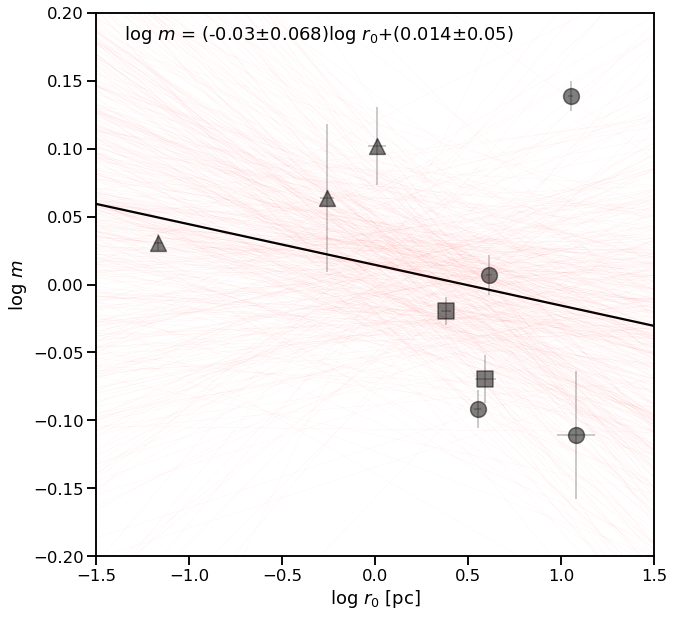

In [36]:
vmin, vmax = -1.5, 1.5
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)

ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[-1.5, 1.5], ylim=[-0.2, 0.2],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $m$",
)

In [37]:
tab=['Y','X','a','b','r','p']

In [38]:
tab0 = ['log $m$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]

- r0 vs sig

In [39]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log r0 [pc]', 'r0er','log sig [km/s]', 'siger']]

lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00247915 0.99300682 1.01762098 1.01697544 1.0064027  1.00240123]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9962157  0.99935944 1.01860937 1.01253509 0.99996729 1.00568579]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99725255 0.99930966 1.01409906 1.00690985 1.00324235 1.00308238]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99778041 1.00019059 1.00494565 1.00531521 1.00261828 0.9991339 ]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99813819 1.00080972 1.00517265 1.01332268 1.00259201 1.00131357]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9984703  1.00046396 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00019279 0.99984998 1.00081692 0.99991577 0.99999983 1.00009114]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00023526 0.99986001 1.00078979 0.9998562  0.99999984 1.00008295]


In [40]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [41]:
pearsonr(X, Y)

(0.5064773091848985, 0.16411202219921095)

In [42]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe         Y        Ye
count  9.000000  9.000000  9.000000  9.000000
mean   0.315556  0.037864  0.725556  0.038123
std    0.705020  0.028566  0.259861  0.027131
min   -1.170000  0.013227  0.430000  0.013611
25%    0.010000  0.017850  0.550000  0.018014
50%    0.550000  0.027269  0.630000  0.029362
75%    0.610000  0.049188  0.860000  0.038112
max    1.080000  0.102599  1.240000  0.083700

[(0.0, 1.5),
 Text(0, 0.5, 'log $\\sigma$ [km/s]'),
 (-1.5, 1.5),
 Text(0.5, 0, 'log $r_{0}$ [pc]')]

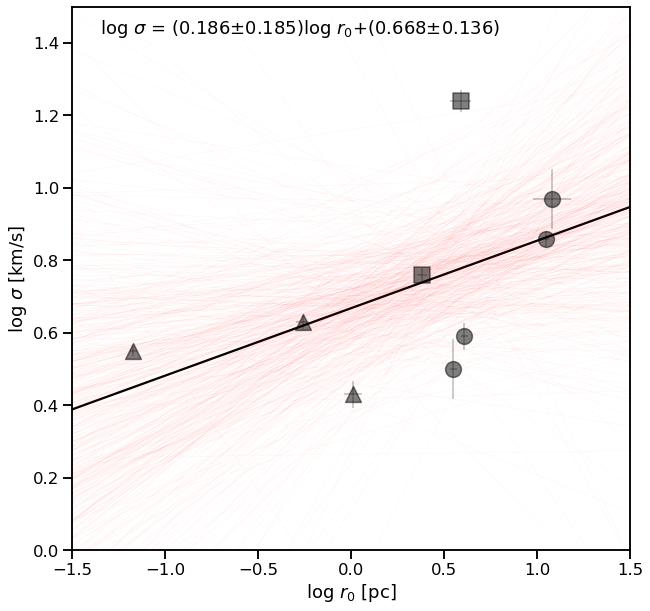

In [43]:
vmin, vmax = -1.5, 1.5
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $r_{0}$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)

    
ax.set(
    xlim=[-1.5, 1.5], ylim=[0, 1.5],
    xlabel=r"log $r_{0}$ [pc]", ylabel=r"log $\sigma$ [km/s]",
)

In [44]:
tab1 = ['log $\sigma$','log $r_{0}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab1

['log $\\sigma$', 'log $r_{0}$', 0.19, 0.18, 0.67, 0.14, 0.51, 0.164]

- log sig vs log m

In [45]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log sig [km/s]', 'siger','m', 'mer']]

In [46]:
Y=np.log10(Y)

In [47]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [48]:
lm.run_mcmc(silent=True)

In [49]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [50]:
pearsonr(X, Y)

(-0.37036315884341164, 0.32651161916589955)

In [51]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe         Y        Ye
count  9.000000  9.000000  9.000000  9.000000
mean   0.725556  0.038123  0.005677  0.022674
std    0.259861  0.027131  0.086722  0.017132
min    0.430000  0.013611 -0.110656  0.006243
25%    0.550000  0.018014 -0.069580  0.010812
50%    0.630000  0.029362  0.006935  0.014897
75%    0.860000  0.038112  0.063841  0.028784
max    1.240000  0.083700  0.138735  0.054292

[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (0.0, 1.5),
 Text(0.5, 0, 'log $\\sigma$ [km/s]')]

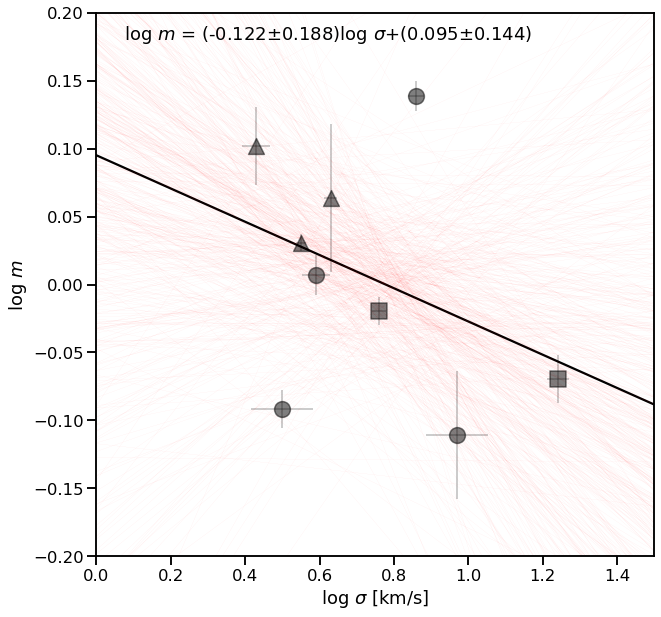

In [52]:
vmin, vmax = 0, 1.5
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0, 1.5], ylim=[-0.2, 0.2],
    xlabel=r"log $\sigma$ [km/s]", ylabel=r"log $m$",
)

In [53]:
dfchain['sigsqr'].mean(),dfchain['corr'].mean(),dfchain['alpha'].mean(),dfchain['beta'].mean(),dfchain['ximean'].mean(),dfchain['xisig'].mean()

(0.017080960088738748,
 -0.2795950827390516,
 0.09510979348526759,
 -0.12231938324358725,
 0.7195529881804749,
 0.395444038590767)

In [54]:
tab2 = ['log $m$','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab2

['log $m$', 'log $\\sigma$', -0.12, 0.19, 0.1, 0.14, -0.37, 0.327]

# Correlation between results and HII regions properties

- Diam(D) vs r0

In [55]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log r0 [pc]', 'r0er']]
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)
lm.run_mcmc(silent=True)

In [56]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [57]:
pearsonr(X, Y)

(0.8598299179217761, 0.0029519788808670504)

In [58]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X      Xe         Y        Ye
count  9.000000  9.0000  9.000000  9.000000
mean   2.091111  0.0434  0.315556  0.037864
std    0.640106  0.0000  0.705020  0.028566
min    0.700000  0.0434 -1.170000  0.013227
25%    2.110000  0.0434  0.010000  0.017850
50%    2.300000  0.0434  0.550000  0.027269
75%    2.570000  0.0434  0.610000  0.049188
max    2.600000  0.0434  1.080000  0.102599

In [59]:
len(lm.chain[::150])

67

[(-1.5, 1.5),
 Text(0, 0.5, 'log $r_0$ [pc]'),
 (0.5, 3.0),
 Text(0.5, 0, 'log $D$ [pc]')]

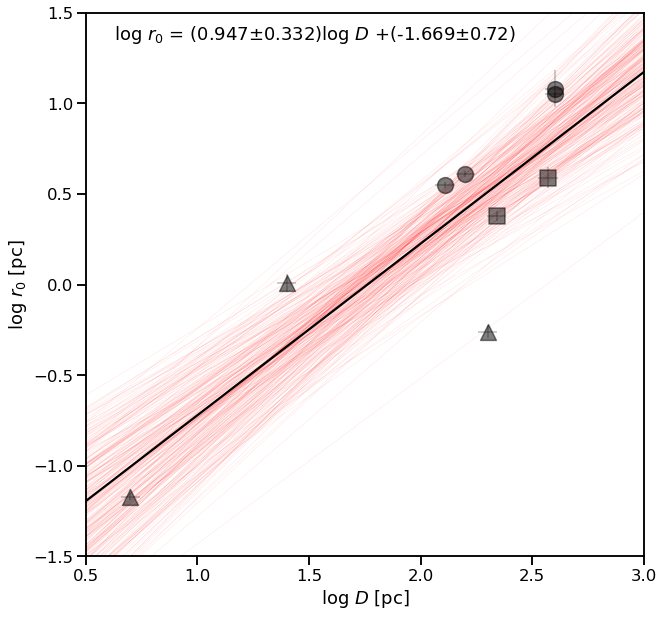

In [60]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))


# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")

sigma=1.0
for samp in lm.chain[::25]:
    if ((dfchain["beta"].mean()-sigma*dfchain["beta"].std() )< samp["beta"] < (sigma*dfchain["beta"].std()+dfchain["beta"].mean())) & \
       ((dfchain["alpha"].mean()-sigma*dfchain["alpha"].std() )< samp["alpha"] < (sigma*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
            '-', c="r",alpha=0.15, lw=0.35,zorder=0)
    
ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=6)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.50)
    
ax.text(.05, .95,'log $r_0$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $D$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.5, 3], ylim=[-1.5, 1.5],
    xlabel=r"log $D$ [pc]", ylabel=r"log $r_0$ [pc]",
)

#plt.savefig('Imgs//corr-rvsS.pdf', bbox_inches='tight')


In [61]:
dfchain['sigsqr'].mean(),dfchain['corr'].mean(),dfchain['alpha'].mean(),dfchain['beta'].mean(),dfchain['ximean'].mean(),dfchain['xisig'].mean()

(0.34358061303526377,
 0.7576471317482991,
 -1.6685180473272336,
 0.9470641053113075,
 2.146457462521805,
 0.948907368755922)

In [62]:
tab3 = ['log $r_0$','log $D$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab3

['log $r_0$', 'log $D$', 0.95, 0.33, -1.67, 0.72, 0.86, 0.003]

- L vs sig

In [63]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [64]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [65]:
lm.run_mcmc(silent=True)

In [66]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [67]:
pearsonr(X, Y)

(0.8588906457651033, 0.003018890674759111)

In [68]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe         Y        Ye
count   9.000000  9.000000  9.000000  9.000000
mean   38.481111  0.043510  0.725556  0.038123
std     0.788471  0.000331  0.259861  0.027131
min    37.180000  0.043400  0.430000  0.013611
25%    38.210000  0.043400  0.550000  0.018014
50%    38.540000  0.043400  0.630000  0.029362
75%    38.950000  0.043400  0.860000  0.038112
max    39.470000  0.044392  1.240000  0.083700

[(0.0, 1.35),
 Text(0, 0.5, 'log $\\sigma_{pos}$ [km/s]'),
 (37.0, 39.75),
 Text(0.5, 0, 'log $L(\\mathrm{H\\alpha})$ [erg s^-1]')]

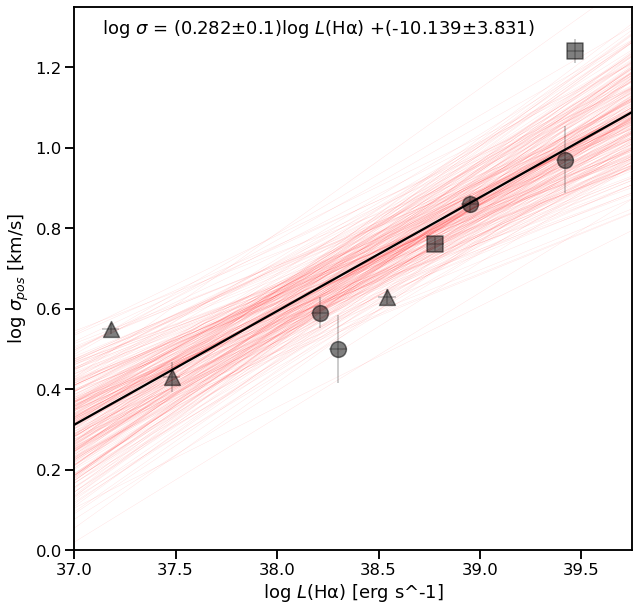

In [69]:

vmin, vmax = 36, 40
xgrid = np.linspace(vmin, vmax, 200)

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k",zorder=10)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)
    

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    if ((dfchain["beta"].mean()-1.0*dfchain["beta"].std() )< samp["beta"] < (1.0*dfchain["beta"].std()+dfchain["beta"].mean())) & \
       ((dfchain["alpha"].mean()-1.0*dfchain["alpha"].std() )< samp["alpha"] < (1.0*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
            '-', c="r",alpha=0.15, lw=0.35,zorder=0)
    
ax.text(.05, .95,r'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + r')log $L(\mathrm{H \alpha})$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[37, 39.75], ylim=[0, 1.35],
    xlabel=r"log $L(\mathrm{H\alpha})$ [erg s^-1]", ylabel=r"log $\sigma_{pos}$ [km/s]",
)

#plt.savefig('Imgs/corr-svsL.pdf', bbox_inches='tight')

In [70]:
dfchain['sigsqr'].mean(),dfchain['corr'].mean(),dfchain['alpha'].mean(),dfchain['beta'].mean(),dfchain['ximean'].mean(),dfchain['xisig'].mean()

(0.04750553446311371,
 0.7780796285026136,
 -10.138996155833576,
 0.2824485149305133,
 38.48888168073437,
 1.2776365853823066)

In [71]:
tab4 = ['log $\sigma$','log L(H)',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],3)]
tab4

['log $\\sigma$', 'log L(H)', 0.28, 0.1, -10.14, 3.83, 0.86, 0.003]

In [72]:
Y, Ye, X, Xe = [logdata[_] for _ in ['log L(H) [erg s^-1]', 'LHaer','log sig [km/s]', 'siger']]

In [73]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [74]:
lm.run_mcmc(silent=True)

In [75]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [76]:
pearsonr(X, Y)

(0.8588906457651033, 0.003018890674759111)

In [77]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe          Y        Ye
count  9.000000  9.000000   9.000000  9.000000
mean   0.725556  0.038123  38.481111  0.043510
std    0.259861  0.027131   0.788471  0.000331
min    0.430000  0.013611  37.180000  0.043400
25%    0.550000  0.018014  38.210000  0.043400
50%    0.630000  0.029362  38.540000  0.043400
75%    0.860000  0.038112  38.950000  0.043400
max    1.240000  0.083700  39.470000  0.044392

[(37.0, 39.75),
 Text(0, 0.5, 'log L(H) [erg s^-1]'),
 (0.2, 1.35),
 Text(0.5, 0, 'log $\\sigma$ [km/s]')]

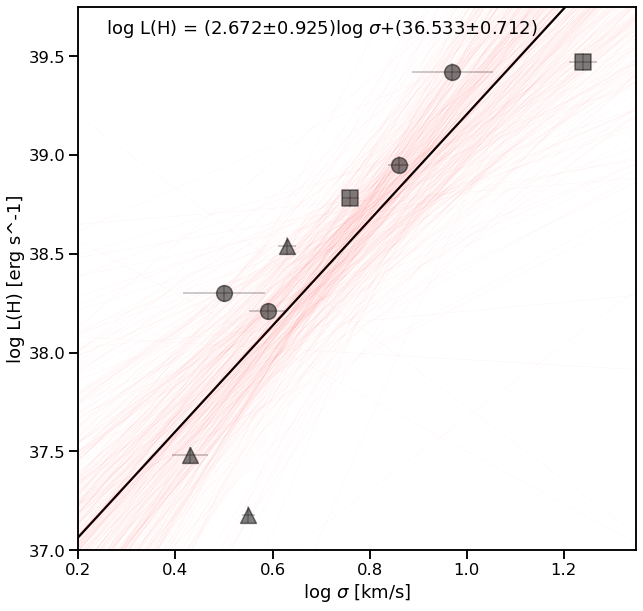

In [78]:
vmin, vmax = 0.2, 1.4
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))
#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log L(H) = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log $\sigma$+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    ylim=[37, 39.75], xlim=[0.2, 1.35],
    ylabel=r"log L(H) [erg s^-1]", xlabel=r"log $\sigma$ [km/s]",
)

In [79]:
tab5 = ['log L(H)','log $\sigma$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab5

['log L(H)', 'log $\\sigma$', 2.67, 0.93, 36.53, 0.71, 0.86, 0.0]

In [80]:
dfchain['sigsqr'].mean(),dfchain['corr'].mean(),dfchain['alpha'].mean(),dfchain['beta'].mean(),dfchain['ximean'].mean(),dfchain['xisig'].mean()

(0.4307551457643481,
 0.7742417115279537,
 36.532700826409304,
 2.672240958936049,
 0.7197084095145342,
 0.4318362998421496)

- Distance (D) vs m

In [81]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log Dist [kpc]', 'Dister [kpc]','m', 'mer']]

In [82]:
Y=np.log10(Y)

In [83]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [84]:
lm.run_mcmc(silent=True)

In [85]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [86]:
pearsonr(X, Y)

(-0.3979284637318914, 0.2888409360496274)

In [87]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe         Y        Ye
count  9.000000  9.000000  9.000000  9.000000
mean   1.644444  0.019498  0.005677  0.022674
std    1.308435  0.012719  0.086722  0.017132
min   -0.400000  0.001649 -0.110656  0.006243
25%    0.370000  0.009234 -0.069580  0.010812
50%    1.790000  0.015500  0.006935  0.014897
75%    2.700000  0.034720  0.063841  0.028784
max    2.920000  0.034720  0.138735  0.054292

[(-0.2, 0.2),
 Text(0, 0.5, 'log $m$'),
 (-1.0, 3.0),
 Text(0.5, 0, 'log Dist [kpc]')]

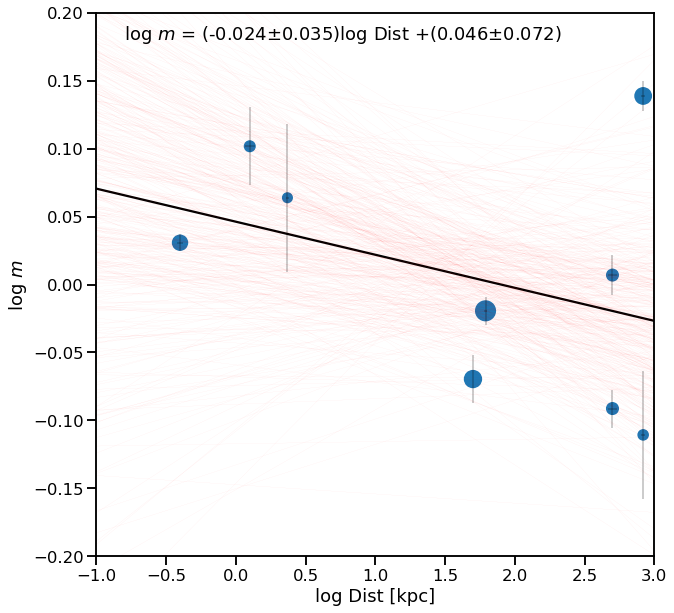

In [88]:
vmin, vmax = -1.0, 3.2
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $m$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log Dist +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
  xlim=[-1.0, 3.0], ylim=[-0.2, 0.2],
    xlabel=r"log Dist [kpc]", ylabel=r"log $m$",
)

In [89]:
tab6 = ['log $m$','log Dist',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab6

['log $m$', 'log Dist', -0.02, 0.03, 0.05, 0.07, -0.4, 0.29]

- siglos vs sig

In [90]:
Y, Ye, X, Xe = [data[_] for _ in ['siglos [km/s]', 'sigloser [km/s]','sig [km/s]', 'siger']]

In [91]:
#Y = data['siglos [km/s]']
#Ye=data['sigloser [km/s]']
#X = data['sig [km/s]']
#Xe = data['siger']

<ErrorbarContainer object of 3 artists>

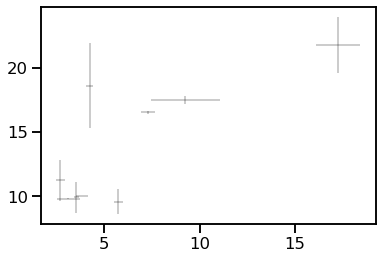

In [92]:
plt.errorbar(X, Y, xerr=Xe, yerr=Ye, ls="", elinewidth=0.4, alpha=1.0, c="k")

In [93]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [94]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99234612 0.9917251  0.99816981 1.09589457 0.99693633 1.00334742]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99918086 0.99647645 0.99842017 1.0257816  1.00071264 1.00217502]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99989153 0.99727226 1.003156   1.00905035 1.00088889 1.00284068]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99890925 0.99830468 0.99878659 1.00998883 1.00070945 1.00055133]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99887315 0.9990343  1.00141533 1.00856332 0.99998821 1.00206387]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9986878  0.99871505 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00055208 1.00046948 1.00004552 1.00059511 0.99999581 1.00014563]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00049903 1.00039316 1.00002428 1.00048678 0.99999589 1.00027187]


In [95]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)

In [96]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X        Xe          Y        Ye
count   9.000000  9.000000   9.000000  9.000000
mean    6.341379  0.557066  13.880000  1.082222
std     4.616870  0.559667   4.713104  1.134050
min     2.717570  0.111537   9.580000  0.020000
25%     3.556403  0.233960   9.900000  0.090000
50%     4.258828  0.337975  11.250000  1.000000
75%     7.294269  0.604475  17.510000  1.600000
max    17.249252  1.780193  21.770000  3.300000

In [97]:
dfchain["beta"].mean()

0.9041492670455181

In [98]:
2*dfchain["beta"].std()+dfchain["beta"].mean()

1.6125512625761371

In [99]:
dfchain["beta"].mean()-2*dfchain["beta"].std()

0.19574727151489912

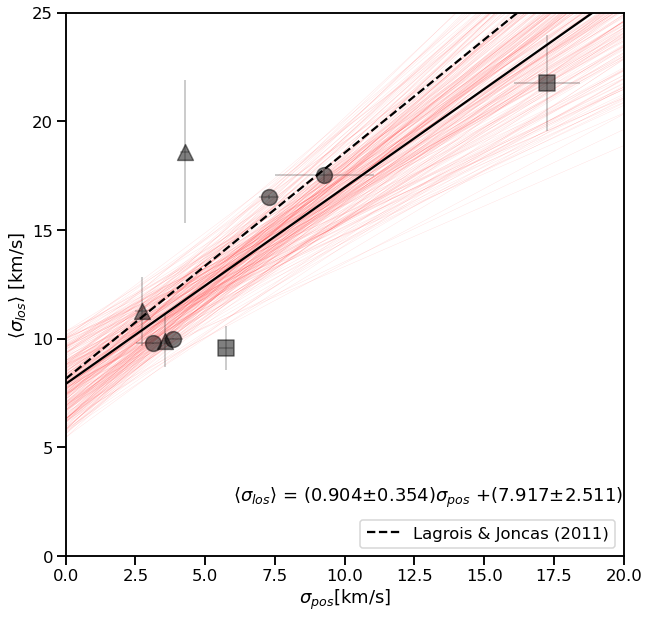

In [100]:
vmin, vmax = 0, 25
xgrid = np.linspace(vmin, vmax, 200)

marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

#ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)
    
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::25]:
    if ((dfchain["beta"].mean()-1.0*dfchain["beta"].std() )< samp["beta"] < (1.0*dfchain["beta"].std()+dfchain["beta"].mean())) & \
       ((dfchain["alpha"].mean()-1.0*dfchain["alpha"].std() )< samp["alpha"] < (1.0*dfchain["alpha"].std()+dfchain["alpha"].mean()) ):
        ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
            '-', c="r",alpha=0.15, lw=0.35,zorder=0)
    
#ax.plot(xgrid,xgrid*1+0,linestyle='solid',color='gray',zorder=0)
#ax.plot(xgrid,xgrid*2+0,linestyle='solid',color='gray',zorder=0)
ax.plot(xgrid,xgrid*1.04+8.15,linestyle='dashed',color='k', label= 'Lagrois & Joncas (2011)',zorder=1)

    
ax.text(.30, .10,r"$ \langle \sigma_{los} \rangle $ = ("  
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')$\sigma_{pos}$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0, 20], ylim=[0, 25],
    xlabel=r"$\sigma_{pos}$[km/s]", ylabel=r"$ \langle \sigma_{los} \rangle $ [km/s]",
)

plt.legend(loc='lower right')    


#plt.savefig('Imgs/corr-los-vs-pos.pdf', bbox_inches='tight')

In [101]:
tab7 = ['$\sigma_{pos}$','$\sigma_{los}$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab7

['$\\sigma_{pos}$', '$\\sigma_{los}$', 0.9, 0.35, 7.92, 2.51, 0.78, 0.01]

In [102]:
x,y,z=X,Y,Ye
XX = sm.add_constant(X)
model = sm.WLS(y, XX,weights=1./(z**2))
results = model.fit()
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:          siglos [km/s]   R-squared:                       0.871
Model:                            WLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     47.24
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           0.000237
Time:                        08:05:59   Log-Likelihood:                -24.303
No. Observations:                   9   AIC:                             52.61
Df Residuals:                       7   BIC:                             53.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6606      0.820      5.682      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [103]:
results.params

const         4.66055
sig [km/s]    1.46384
dtype: float64

In [104]:
results.bse

const         0.820168
sig [km/s]    0.212990
dtype: float64

- sig vs S

In [105]:
X, Xe, Y, Ye = [logdata[_] for _ in ['log L [pc]', 'Ler [pc]','log sig [km/s]', 'siger']]

In [106]:
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)

In [107]:
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99846953 0.99834033 1.02208072 1.03278038 1.0177787  1.00594794]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99642056 0.99577038 1.00348159 1.00534937 1.00016776 0.99768164]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99668232 0.99678243 1.00495774 1.00839584 1.00122331 0.99994646]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99764705 0.99750189 1.00183899 1.01212485 1.0010504  0.99827583]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99882476 0.99858365 0.99883732 1.0068613  1.00196257 0.9987849 ]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99925754 0.99949528 1


Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00010134 1.00009696 0.9999667  1.00081118 0.99996656 0.99990552]


In [108]:
dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain

In [109]:
pearsonr(X, Y)

(0.6442009228845607, 0.06111620558103185)

In [110]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

X      Xe         Y        Ye
count  9.000000  9.0000  9.000000  9.000000
mean   2.091111  0.0434  0.725556  0.038123
std    0.640106  0.0000  0.259861  0.027131
min    0.700000  0.0434  0.430000  0.013611
25%    2.110000  0.0434  0.550000  0.018014
50%    2.300000  0.0434  0.630000  0.029362
75%    2.570000  0.0434  0.860000  0.038112
max    2.600000  0.0434  1.240000  0.083700

[(0.2, 1.4),
 Text(0, 0.5, '$\\sigma$ [km/s]'),
 (0.5, 3.0),
 Text(0.5, 0, '$S$[km/s]')]

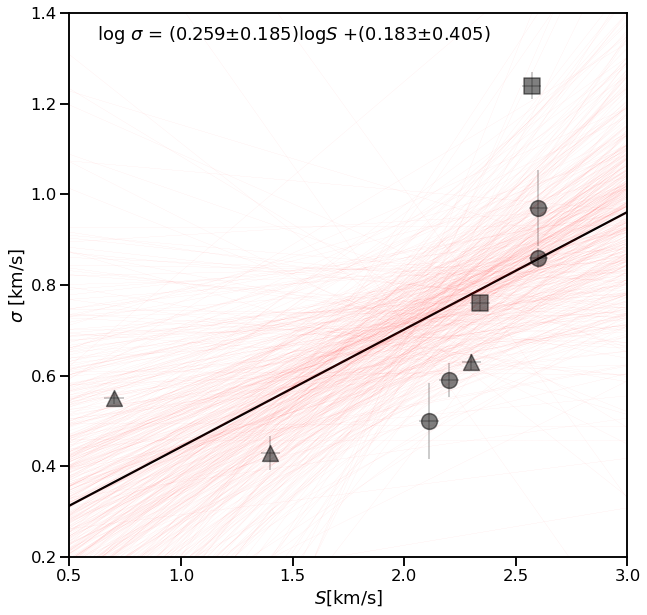

In [111]:
vmin, vmax = -0.5, 3
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

#ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
marker=itertools.cycle(('o','o','o','o','s','^','s','^','^'))

#for i in [0,1,2,3,4,6,8]:
for i in range(len(samples)):
    ax.scatter(X[i], Y[i], marker=next(marker), s=250,zorder=5, c ='k', alpha=0.5)

# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.25, lw=0.1)
    
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log$S$ +('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
    xlim=[0.5, 3.0], ylim=[0.2, 1.4],
    xlabel=r"$S$[km/s]", ylabel=r"$\sigma$ [km/s]",
)

#plt.savefig('Imgs//svss.pdf', bbox_inches='tight')

In [112]:
tab8 = ['log $\sigma$','log $S$',np.round(dfchain["beta"].mean(),2),np.round(dfchain["beta"].std(),2),
       np.round(dfchain["alpha"].mean(),2),np.round(dfchain["alpha"].std(),2),
      np.round(pearsonr(X, Y)[0],2),np.round(pearsonr(X, Y)[1],2)]
tab8

['log $\\sigma$', 'log $S$', 0.26, 0.19, 0.18, 0.41, 0.64, 0.06]

Results to table

In [113]:
Corr = pd.DataFrame([tab0, tab1,tab2,tab3,tab4,tab6,tab7,tab8])
Corr.rename(columns={0:'A',1:'B',2:'C',3:'DC',4:'E',5:'DE',6:'F',7:'G'}, inplace=True)
Corr=Corr.sort_values( by='G', ascending=True)
Corr

A               B     C    DC      E    DE     F      G
3       log $r_0$         log $D$  0.95  0.33  -1.67  0.72  0.86  0.003
4    log $\sigma$        log L(H)  0.28  0.10 -10.14  3.83  0.86  0.003
6  $\sigma_{pos}$  $\sigma_{los}$  0.90  0.35   7.92  2.51  0.78  0.010
7    log $\sigma$         log $S$  0.26  0.19   0.18  0.41  0.64  0.060
1    log $\sigma$     log $r_{0}$  0.19  0.18   0.67  0.14  0.51  0.164
5         log $m$        log Dist -0.02  0.03   0.05  0.07 -0.40  0.290
2         log $m$    log $\sigma$ -0.12  0.19   0.10  0.14 -0.37  0.327
0         log $m$     log $r_{0}$ -0.03  0.07   0.01  0.05 -0.28  0.469

In [114]:
Corrx=(Corr.groupby(Corr.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply(' $\pm$ '.join, 1)))
Corr1=Corrx[['A','B','C','E','F','G']].copy()

In [115]:
Corr1.rename(columns={'A':'Y','B':'X','C':'a','E':'b','F':'r','G':'p'}, inplace=True)
Corr1

Y               X                 a                  b      r  \
3       log $r_0$         log $D$   0.95 $\pm$ 0.33   -1.67 $\pm$ 0.72   0.86   
4    log $\sigma$        log L(H)    0.28 $\pm$ 0.1  -10.14 $\pm$ 3.83   0.86   
6  $\sigma_{pos}$  $\sigma_{los}$    0.9 $\pm$ 0.35    7.92 $\pm$ 2.51   0.78   
7    log $\sigma$         log $S$   0.26 $\pm$ 0.19    0.18 $\pm$ 0.41   0.64   
1    log $\sigma$     log $r_{0}$   0.19 $\pm$ 0.18    0.67 $\pm$ 0.14   0.51   
5         log $m$        log Dist  -0.02 $\pm$ 0.03    0.05 $\pm$ 0.07   -0.4   
2         log $m$    log $\sigma$  -0.12 $\pm$ 0.19     0.1 $\pm$ 0.14  -0.37   
0         log $m$     log $r_{0}$  -0.03 $\pm$ 0.07    0.01 $\pm$ 0.05  -0.28   

       p  
3  0.003  
4  0.003  
6   0.01  
7   0.06  
1  0.164  
5   0.29  
2  0.327  
0  0.469

In [116]:
#Corr1.to_latex('latex-files/scaling-relations.tex', escape=False, caption='Regressions (Y = aX + b).',index=False)

In [117]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 72.48254632949829 seconds ---


In [118]:
!jupyter nbconvert --to script --no-prompt correlations-regressions_1sigma.ipynb

[NbConvertApp] Converting notebook correlations-regressions_1sigma.ipynb to script
[NbConvertApp] Writing 30610 bytes to correlations-regressions_1sigma.py
